In [1]:
%gui qt
from collections import defaultdict
import numpy as np
from mayavi import mlab
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from kifmm_py import (
    KiFmm,
    LaplaceKernel,
    SingleNodeTree,
    EvalType,
    BlasFieldTranslation,
    FftFieldTranslation,
    read_stl_triangle_mesh_vertices
)

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
(sources, faces) = read_stl_triangle_mesh_vertices("battleship.STL")
x = sources[:, 0]
y = sources[:, 1]
z = sources[:, 2]

In [3]:
# mlab.view(azimuth=40, elevation=70, distance="auto", focalpoint="auto")
# fig = mlab.figure(
#     size=(960, 1080), bgcolor=(1, 1, 1)
# )  # This sets the window size for rendering
# plot = mlab.triangular_mesh(
#     x, y, z, faces, color=(0.5, 0.5, 0.5), representation="points", figure=fig
# )
# mlab.show()

In [4]:
dtype = np.float64

# # Set FMM Parameters
expansion_order = np.array([6])
# n_vec = 1
n_crit = 15
n_sources = sources.shape[0]
n_targets = sources.shape[0]

# n_sources = 1000
# n_targets = 2000
# dim = 3
# # Setup source/target/charge data in Fortran order
# sources = np.random.rand(n_sources * dim).astype(dtype)
# targets = np.random.rand(n_targets * dim).astype(dtype)
# charges = np.random.rand(n_sources).astype(dtype)

sources = sources.flatten().astype(dtype)
charges = np.random.rand(n_sources).astype(dtype)

# Set Random charges
# charges = np.random.rand(n_sources).astype(dtype)

kernel = LaplaceKernel(
    dtype, EvalType.Value
) 

field_translation = BlasFieldTranslation(
    kernel, svd_threshold=dtype(1e-16), surface_diff=2, random=True, n_components=100, n_oversamples=10
)

tree = SingleNodeTree(sources, sources, charges, n_crit=n_crit, prune_empty=True)

fmm = KiFmm(expansion_order, tree, field_translation, timed=True)

fmm.evaluate()
fmm.unsort_all_potentials()

CONSTRUCTOR SUCCESFUL Some(8912)
Reconstructed leaves target tree
Reconstructed leaves source treee
Reconstructed global indices
Reconstructed
Evaluated
Reconstructed Potentials


# Plot Solution

In [5]:
mlab.view(azimuth=40, elevation=70, distance="auto", focalpoint="auto")
fig = mlab.figure(
    size=(960, 1080), bgcolor=(1, 1, 1)
)  # This sets the window size for rendering
solution = mlab.triangular_mesh(
    x, y, z, faces, scalars=np.log(fmm.all_potentials_r).flatten(), representation="surface"
)

colorbar = mlab.colorbar(solution, title='Log-scaled values', orientation='vertical')
colorbar.title_text_property.font_size = 10
colorbar.label_text_property.font_size = 8
mlab.show()

# Statistics

In [6]:
# Examine result at leaf index
leaf = fmm.leaves_target_tree[23]
targets_leaf = fmm.coordinates_target_tree(leaf)
found = fmm.leaf_potentials(leaf)
expected = np.zeros_like(found)
fmm.evaluate_kernel(EvalType.Value, sources, targets_leaf, charges, expected[0])

# Test
np.testing.assert_allclose(found, expected, rtol=1e-5)

stats = defaultdict(int)

for leaf in fmm.leaves_target_tree:
    found = fmm.coordinates_target_tree(leaf)
    n = found.shape[0]
    stats[n] += 1

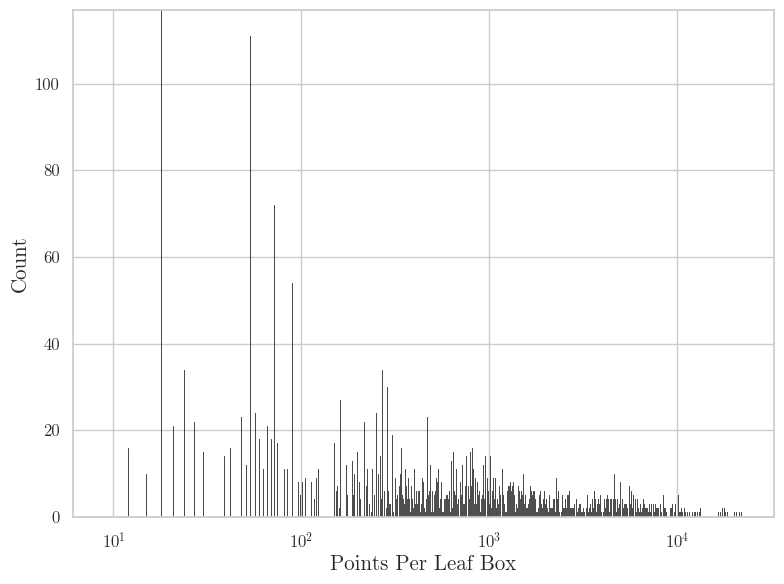

In [7]:
# # Plot the histogram using seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))

# Convert the dictionary to a pandas DataFrame
data = []
for points, occurrences in stats.items():
    data.extend([points] * occurrences)

df = pd.DataFrame(data, columns=['Points'])

hist_plot = sns.histplot(df, x='Points', bins=len(stats), color='black', log_scale=(True, False))

# Load CMU font
import matplotlib.font_manager as fm
font_path = "/Users/sri/Downloads/cmu/cmunrm.ttf"
font_properties = fm.FontProperties(fname=font_path)

hist_plot.set_xlabel('Points Per Leaf Box', fontsize=15, fontproperties=font_properties)
hist_plot.set_ylabel('Count', fontsize=15, fontproperties=font_properties)

hist_plot.set_ybound(lower=None, upper=117)
# Set font properties for tick labels
for label in hist_plot.get_xticklabels():
    label.set_fontproperties(font_properties)
for label in hist_plot.get_yticklabels():
    label.set_fontproperties(font_properties)

plt.tight_layout()
plt.savefig('stats.svg', format='svg')
plt.show()